# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [176]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1/Transfer Learning/MobileNetV3Large

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1/Transfer Learning/MobileNetV3Large


## ⚙️ Import Libraries

In [ ]:
pip install tensorflow==2.17.0 keras==3.4.1 keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [ ]:
# Set seed for reproducibility
seed = 42

import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras_cv

np.random.seed(seed)
tf.random.set_seed(seed);

# Print TensorFlow, Keras API for TensorFlow, and KerasCV version
print(f'TensorFlow: {tf.__version__}')
print(f'Keras API for TensorFlow: {tfk.__version__}')
print(f'KerasCV: {keras_cv.__version__}')

TensorFlow: 2.17.0
Keras API for TensorFlow: 3.4.1
KerasCV: 0.9.0


In [ ]:
# Import other necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random

# Set seeds for random number generators in Python
random.seed(seed)

# Set seed for TensorFlow
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries (and some more libraries for image manipulation)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')  # Load the training data here
X = data['images']
y = data['labels']

In [ ]:
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: ' Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

unique_labels = list(labels.values())

print('Labels:\n', unique_labels)

Labels:
 ['Basophil', 'Eosinophil', ' Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [ ]:
# Define a function to display images
def display_images(
    X=X,
    y=y,
    labels=unique_labels,
    num_images=8
):
    random_indices = random.sample(range(len(X)), num_images)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 9))

    for i, idx in enumerate(random_indices):
        ax = axes[i // 4, i % 4]
        ax.imshow(X[idx])

        class_name = unique_labels[y[idx][0]]
        ax.set_title(class_name, pad=5)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

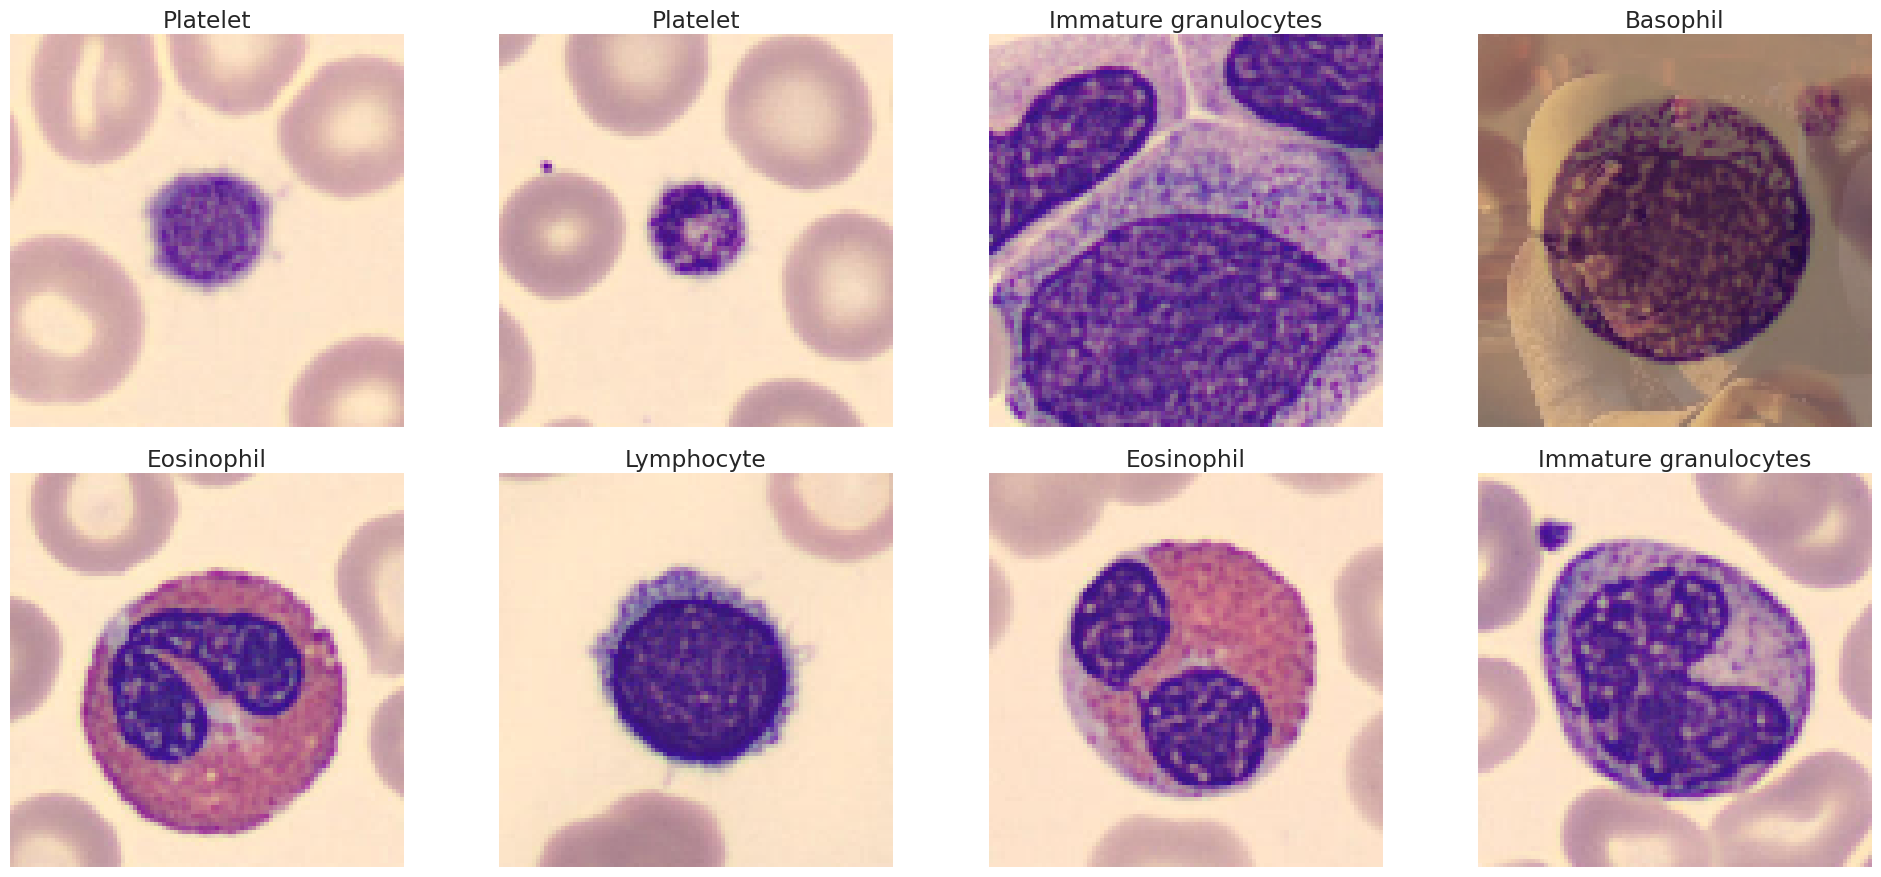

In [ ]:
display_images(X, y)

<class 'numpy.ndarray'>
(13759, 96, 96, 3)
4

Class: [7] Platelet


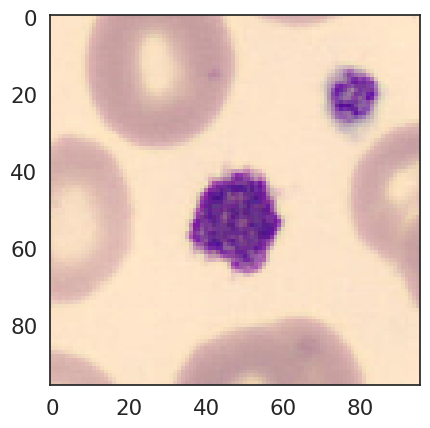

In [ ]:
print(type(X))
print(X.shape)
print(X.ndim)
print('\nClass:', y[0], labels[y[0][0]])
plt.imshow(X[0])

## Inspect Data

In [ ]:
print(f'Dataset Shape: {X.shape}')
print(f'Labels Shape: {y.shape}')

Dataset Shape: (13759, 96, 96, 3)
Labels Shape: (13759, 1)


In [ ]:
print('Counting occurences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurences of target classes:
digit
6    2530
1    2381
3    2226
7    1843
5    1393
2    1285
0    1052
4    1049
Name: count, dtype: int64


Class [5] Monocyte


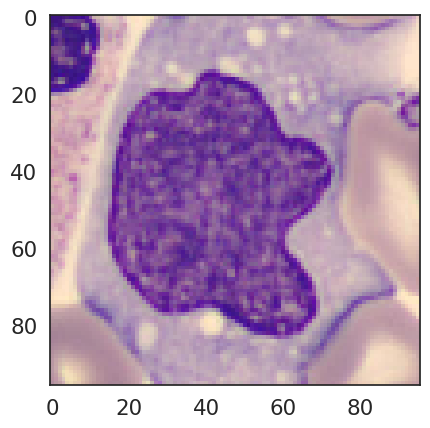

In [ ]:
plt.imshow(X[3025])
print('Class', y[3025], labels[y[3025][0]])

## Process Data

In [ ]:
# Eliminate duplicates
X_unique, idx, count = np.unique(X, return_index=True, return_counts=True, axis=0)
print(idx.shape, '\n')

index = [idx[i] for i in range(idx.shape[0]) if count[i] == 1]

X = X[index]
y = y[index]

print(f'Dataset (no duplicates) Shape: {X.shape}')
print(f'Dataset (no duplicates) Shape: {y.shape}')

(11953,) 

Dataset (no duplicates) Shape: (11943, 96, 96, 3)
Dataset (no duplicates) Shape: (11943, 1)


Class [5] Monocyte


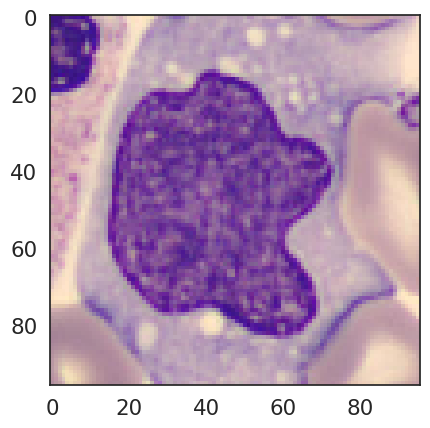

In [ ]:
plt.imshow(X[1])
print('Class', y[1], labels[y[1][0]])

In [ ]:
print('Counting occurences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurences of target classes:
digit
6    2330
1    2177
3    2020
7    1643
2    1085
5     991
4     849
0     848
Name: count, dtype: int64


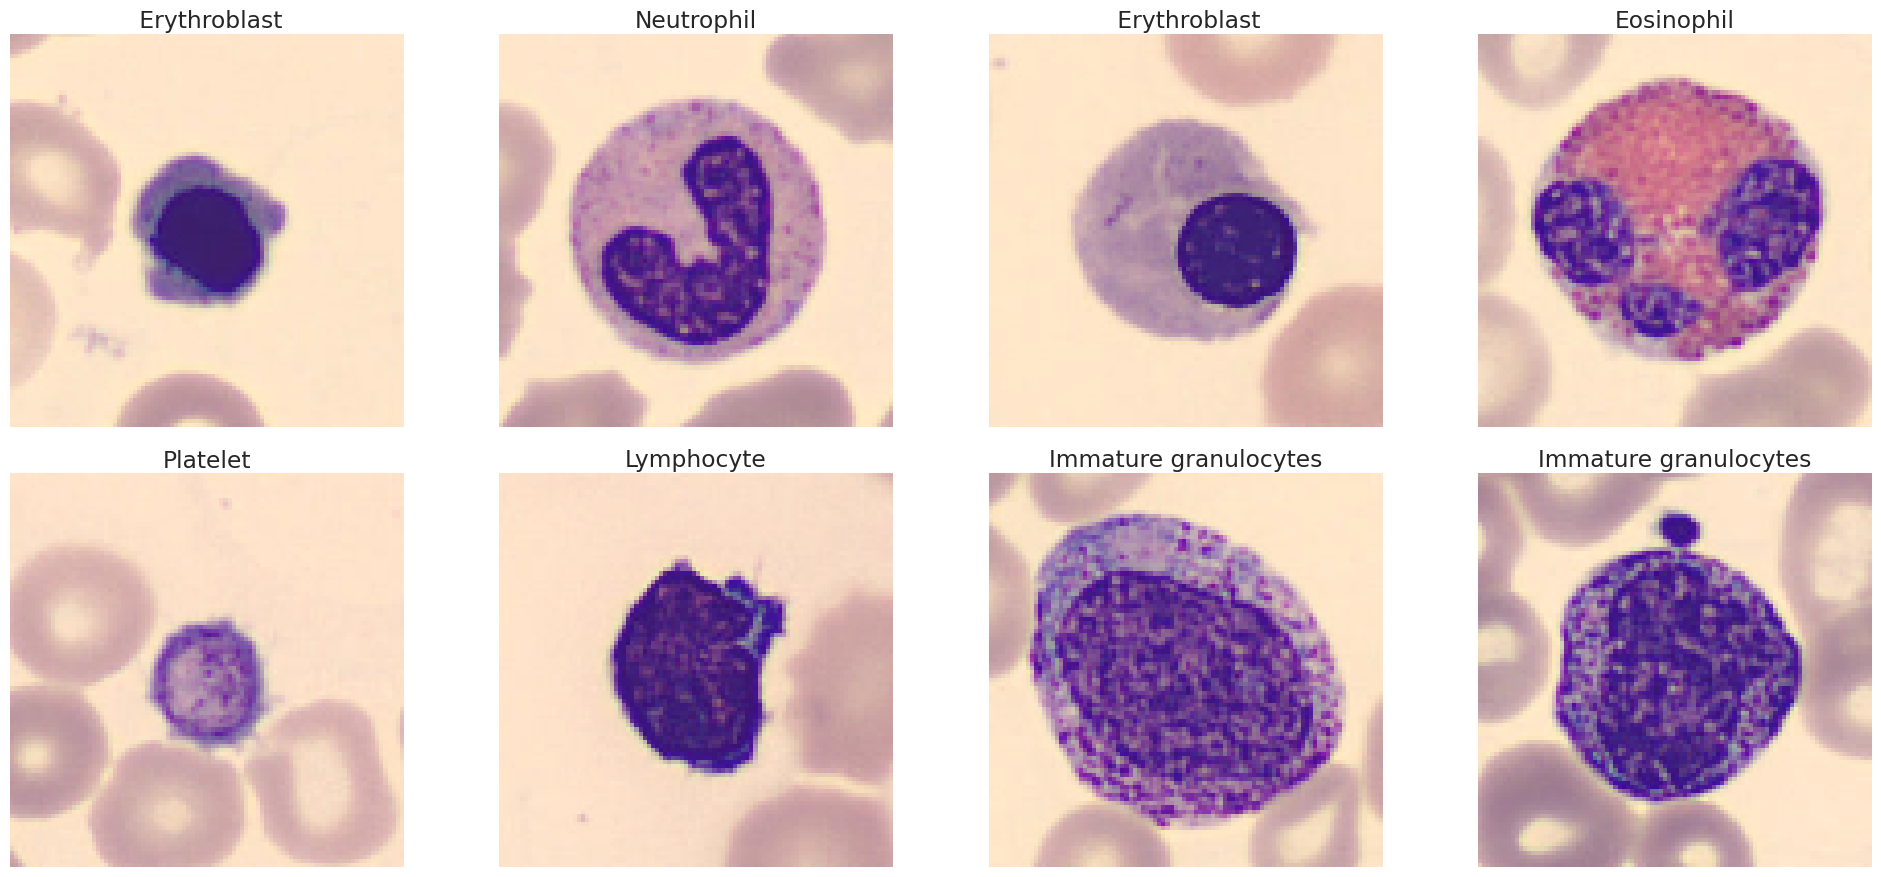

In [ ]:
display_images(X, y)

In [ ]:
# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

## Data Augmentation

In [ ]:
augmenter = keras_cv.layers.Augmenter(
    layers = [
        keras_cv.layers.RandomFlip(
            mode="horizontal_and_vertical"
        ),
        keras_cv.layers.RandomRotation(
            factor=0.2,
            fill_mode='nearest'
        ),
        keras_cv.layers.MixUp(
            alpha=2.0
        ),
        keras_cv.layers.CutMix(
            alpha=1.0
        ),
        keras_cv.layers.AugMix(
            value_range=[0, 255],
            severity=0.3,
            num_chains=2,
            chain_depth=[1,3],
            alpha=1.0
        )
    ]
)

In [ ]:
def augment(images, labels):
    inputs = {"images": images, "labels": labels}
    output = augmenter(inputs)
    return output["images"], output["labels"]

In [ ]:
aug_images, aug_labels = augment(X[:10], y[:10])

In [ ]:
print(type(aug_images))
print(type(aug_images.numpy()))
print(aug_images.shape)
print(type(aug_labels))
print(type(aug_labels.numpy()))
print(aug_labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(10, 96, 96, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(10, 8)


Categorical Label: [0.         0.3027209  0.46012288 0.23715621 0.         0.
 0.         0.        ]


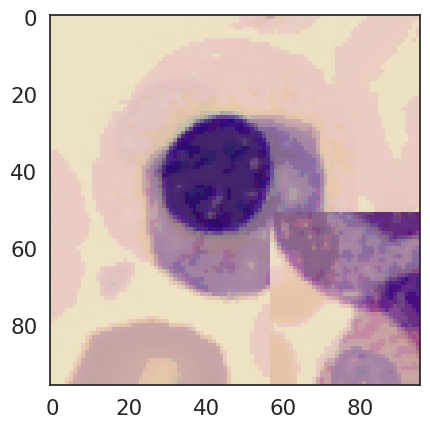

In [ ]:
print(f'Categorical Label: {aug_labels[2].numpy()}')
plt.imshow(aug_images[2].numpy() / 255)

In [ ]:
# Define Data Augmentation Layers
early_augmentation = tf.keras.Sequential(
    [tfkl.RandomFlip("horizontal_and_vertical"),
     tfkl.RandomRotation(factor=0.2, fill_mode='nearest'),
     tfkl.RandomZoom(height_factor=(0.,0.5), fill_mode='nearest'),
     tfkl.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1), fill_mode='nearest'),
     tfkl.RandomBrightness(factor=0.1, value_range=(0.1,0.5)),
     tfkl.RandomContrast(factor=0.3),
     keras_cv.layers.RandomHue(factor=(0.1, 0.5), value_range=[0,1])
     ],
    name = 'preprocessing'
)

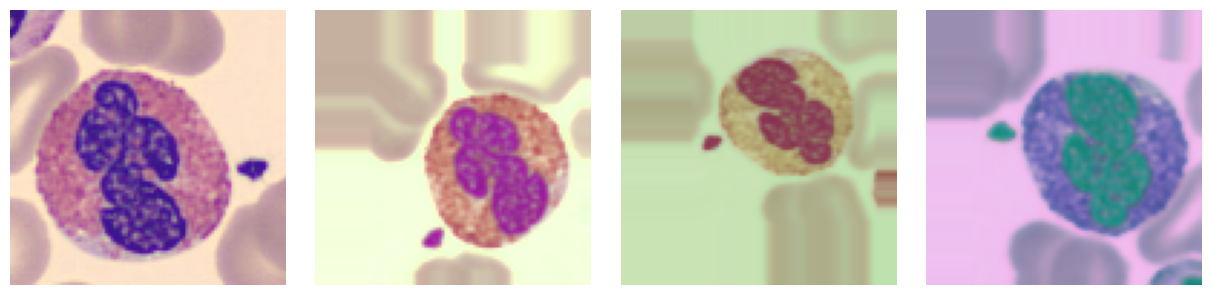

In [ ]:
img = X[2]

fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

augmented_img = np.clip(early_augmentation(img / 255), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

augmented_img = np.clip(early_augmentation(img / 255), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

augmented_img = np.clip(early_augmentation(img / 255), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

plt.show()

## Split Augmented Dataset into Training Set, Validation Set, Test Set

In [ ]:
# TO DO: Integrate Data Augmentation within the preprocessing pipeline before splitting

# Split the augmented dataset into training set, validation set, and test set

# Get training-validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    random_state=seed,
    test_size=0.1,
    stratify=y)

# Get training set and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=len(y_test),
    stratify=y_train_val)

print(f'Training Set Shape: {X_train.shape}')
print(f'Training Labels Shape: {y_train.shape}\n')

print(f'Validation Set Shape: {X_val.shape}')
print(f'Validation Labels Shape: {y_val.shape}\n')

print(f'Test Set Shape: {X_test.shape}')
print(f'Test Labels Shape: {y_test.shape}')

Training Set Shape: (9553, 96, 96, 3)
Training Labels Shape: (9553, 8)

Validation Set Shape: (1195, 96, 96, 3)
Validation Labels Shape: (1195, 8)

Test Set Shape: (1195, 96, 96, 3)
Test Labels Shape: (1195, 8)


In [ ]:
# Compare categorical label and "default" label representation

# Display the categorical label
print(f'Categorical Label: {y_train[0]}')
# Display the equivalent numeric label
print(f'"Default" Label: {np.argmax(y_train[0])}')

Categorical Label: [0. 1. 0. 0. 0. 0. 0. 0.]
"Default" Label: 1


## Define Model Parameters

In [ ]:
input_shape = X.shape[1:]
output_shape = y.shape[-1]

print(f'Input Shape: {input_shape}')
print(f'Output Shape: {output_shape}')

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of epochs
epochs = 150

# Batch Size
batch_size = 128

# Learning Rate
learning_rate = 0.001

print(f'Number of epochs: {epochs}')
print(f'Batch Size: {batch_size}')
print(f'Learning Rate: {learning_rate}')

Number of epochs: 150
Batch Size: 128
Learning Rate: 0.001


## Transfer Learning

In [ ]:
mobilenet = tfk.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='max',
    include_preprocessing=True
)

mobilenet.summary(expand_nested=True)

tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Freeze all layers in MobileNetV3
mobilenet.trainable = False

# Define Data Augmentation Layer
augmentation = tf.keras.Sequential(
    [
        tfkl.RandomFlip(
            "horizontal_and_vertical"
        ),
        tfkl.RandomRotation(
            factor=0.2,
            fill_mode='nearest'
        ),
        tfkl.RandomZoom(
            height_factor=(0.,0.5),
            fill_mode='nearest'
        ),
        tfkl.RandomTranslation(
            height_factor=(-0.1,0.1),
            width_factor=(-0.1,0.1),
            fill_mode='nearest'
        ),
        keras_cv.layers.AugMix(
            value_range=[0,1],
            severity=0.3,
            num_chains=3,
            chain_depth=[1,3],
            alpha=1.0
        ),
    ],
    name = 'preprocessing'
)

# Create the input layer
inputs = tfk.Input(shape=input_shape, name='input_layer')

x = augmentation(inputs)

# Pass augmented inputs to MobileNetV3Large architecture (used as a feature extractor only)
x = mobilenet(x)

# Add a Dropout Layer for Regularization
x = tfkl.Dropout(0.25, name='dropout1')(x)

x = tfkl.Dense(units=512, activation='relu', name='dense1')(x)
x = tfkl.Dropout(0.25, name='dropout2')(x)
x = tfkl.Dense(units=512, activation='relu', name='dense2')(x)
#x = tfkl.Dense(units=512, activation='relu', name='dense3')(x)
#x = tfkl.Dense(units=512, activation='relu', name='dense4')(x)
#x = tfkl.Dense(units=512, activation='relu', name='dense5')(x)

outputs = tfkl.Dense(units=output_shape, activation='softmax', name='output_layer')(x)

model = tfk.Model(
    inputs=inputs,
    outputs=outputs,
    name='model')

model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Lion(learning_rate),
    metrics=['accuracy']
)

model.summary(expand_nested=True)

#tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## Define Early Stopping Callback

In [ ]:
patience = 20

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Compute and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])*100, 2)
print(f'Final Validation Accuracy: {final_val_accuracy}')

model.save('weights.keras')
del model

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training Accuracy', alpha=0.8)
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## Fine Tuning

In [ ]:
# Load the model
model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Plot the model architecture with trainable parameters and layer shapes
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set the MobileNetV3Small model layers as trainable
model.get_layer('MobileNetV3Small').trainable = True

# Set all MobileNetV3Small model layers as non-trainable
for layer in model.get_layer('MobileNetV3Small').layers:
    layer.trainable = False

# Enable training only fot Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('MobileNetV3Small').layers):
  if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
      layer.trainable = True
      print(i, layer.name, type(layer).__name__, layer.trainable)

In [ ]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('MobileNetV3Small').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(model.get_layer('MobileNetV3Small').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with trainable parameters and layer shapes
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Compile the model
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
patience = 20

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Compute and print the Final Validation Accuracy
final_val_accuracy = round(max(history['val_accuracy'])*100, 2)
print(f'Final Validation Accuracy: {final_val_accuracy}%')

model.save('weights.keras')

del model

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training Accuracy', alpha=0.8)
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## Use the Model - Make Inference

In [ ]:
# Load the model
model = tfk.models.load_model('weights.keras')

model.summary(expand_nested=True)

tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Predict labels for the test set
predictions = model.predict(X_test, verbose=0)

# Display the shape for the predictions
print(f'Predictions Shape: {predictions.shape}')

Predictions Shape: (1195, 8)


In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Compute and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Compute and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Compute and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Compute and display test set
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)